In [3]:
from tqdm.notebook import tqdm

from multiprocessing import Pool, cpu_count
from functools import partial
from itertools import repeat

import matplotlib.pyplot as plt

import numpy as np

from scipy.fft import fft, fftfreq, ifft
from scipy.optimize import curve_fit

from timescales.sim import sim_branching
from timescales.fit import convert_knee_val

from neurodsp.sim import sim_oscillation, sim_bursty_oscillation
from neurodsp.utils.norm import normalize_sig
from neurodsp.spectral import compute_spectrum

from spectrum import pburg
from statsmodels.tsa.api import ARIMA

### Autoregressive Decomposition
This notebook uses a modified version of "canonical autoregressive decomposition" (CAD) decribed in (Nagesha & Kay, 1994). CAD involves modeling sinusoids separately from AR coefficients. The modification include here adds a parameter allowing non-sinusoidality in the oscillatory term.


#### Aperiodic: AR(p) Model
$$A_{n} = \sum_{k=1}^{p}a_{k} X_{n-k} + \varepsilon_{n}$$

#### Periodic: Non-Sinusoidal Oscillatory Model

$$w_{i} = \phi{i}e^{2j\pi f n}$$

$$z_{i} = w_{i} \cdot e^{j c_{i} w+{i}}$$

$$P_{n} = \sum_{i=1}^{s}z_{i}$$

#### Full Model

$$x_{n} = \sum_{i=1}^{s}z_{i} + \sum_{i=1}^{p}a_{k} X_{n-k} + \varepsilon_{n}$$

In [16]:
def decompose_ar(xs, ys, fs, s_order, p_order, *fit_args,
                 return_components=False):

    heights, phis, freqs, cs = np.array(fit_args).reshape(s_order, -1).T
    
    # Construct (asym) oscillation
    if s_order > 0:
        osc_fit = np.zeros(len(xs))
        for i in range(s_order):

            pha = np.exp(1.j * np.pi * phis[i])

            w = heights[i] * pha * np.exp(2.j * np.pi * (freqs[i]/fs) * xs)

            osc_fit +=  (w * np.exp(1.j * cs[i] * w)).real

        s = osc_fit.real
    
    if p_order == 0:
        return s
    
    # Fit ARIMA
    ar = ARIMA(ys-s, order=(p_order, 0, 0)).fit(method='burg')
    w = ar.fittedvalues
    
    if return_components:
        
        params = {'ar_'+k:v for k, v in zip(ar.param_names, ar.params)}
        params['osc_height'] = heights
        params['osc_phis'] = phis
        params['osc_freqs'] = freqs
        params['osc_asym'] = cs
        
    if p_order > 0 and s_order > 0 and return_components:
        return s, w, params
    elif p_order > 0 and return_components:
        return w, params
    elif s_order > 0 and return_components:
        return s, params
    else:
        return s + w


def fit(xs, ys, fs, s_order, p_order, bounds=None, guess=None, maxfev=1000):
    
    if bounds is None:
        bounds = [
            [.2, -1, 0, -1] * s_order,
            [ 2,  1, 100, 1] * s_order
        ]
    
    if guess is None:
        guess = [1, 0, 1, 0] * s_order
        
    params, _ = curve_fit(
        lambda xs, *args : decompose_ar(xs, ys, fs, s_order, p_order, *args),
        xs, ys, bounds=bounds, p0=guess, maxfev=maxfev, method='trf'
    )
    
    return params


def windowed_fit(xs, ys, fs, s_order, p_order, nperseg, noverlap,
                 bounds=None, guess=None, maxfev=1000, njobs=-1):
    
    # Window signal
    inds = np.arange(0, len(xs)-nperseg+1, nperseg-noverlap)

    starts = inds
    ends = inds + nperseg

    sig_win = np.array([sig[s:e] for s, e in zip(starts, ends)])
    xs_win = np.arange(len(sig_win[0]))
    
    # Parallel
    njobs = cpu_count() if njobs == -1 else njobs
    with Pool(njobs) as pool:
        
        args = zip(repeat(xs_win), sig_win, repeat(fs), repeat(s_order),
                   repeat(p_order), repeat(bounds), repeat(guess), repeat(maxfev))
        
        mapping = pool.starmap(fit, args)
        
        osc_params = np.array(list(tqdm(mapping, total=len(sig_win))))
        
    # Regenerate fits
    t_def = np.column_stack((starts, ends))
    
    s = np.zeros_like(sig_win)
    
    params = []
    
    if p_order > 0:
        
        w = np.zeros_like(sig_win)
        
        for ind, (_sig, _params) in enumerate(zip(sig_win, osc_params)):
            
            _s, _w,  _full_params = decompose_ar(xs_win, _sig, fs, s_order, p_order,
                                                 *_params, return_components=True)
            s[ind] = _s
            w[ind] = _w
            
            params.append(_full_params)
            
        return s, w, params, t_def
    
    else:
        
        for ind, (_sig, _params) in enumerate(zip(sig_win, osc_params)):
            
            _s, _full_params = decompose_ar(xs_win, _sig, fs, s_order, p_order,
                                            *_params, return_components=True)
            
            s[ind] = _s
            params.append(_full_params)
        
        return s, params, t_def

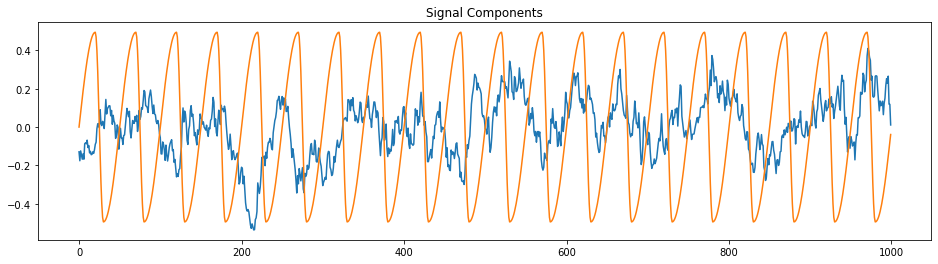

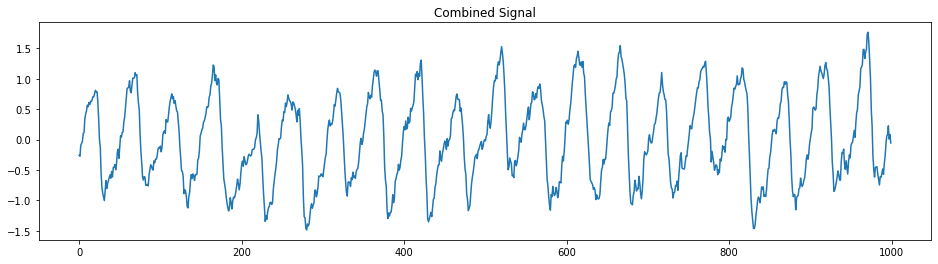

In [5]:
n_seconds = 1
fs = 1000
tau = convert_knee_val(10)

lfp = sim_branching(n_seconds, fs, tau, 100)
lfp = normalize_sig(lfp, 0, 1)
#osc = sim_oscillation(n_seconds, fs, 20)
osc = sim_oscillation(n_seconds, fs, 20, 'asine', rdsym=.8)

osc_var = .7
osc = osc * osc_var
lfp = lfp * (1-osc_var)
sig = lfp + osc

plt.figure(0, figsize=(16, 4))
plt.title('Signal Components')
plt.plot(lfp/2)
plt.plot(osc/2)

plt.figure(1, figsize=(16, 4))
plt.title('Combined Signal')
plt.plot(sig);

In [17]:
ys = sig
xs = np.arange(len(ys))

s_order = 8
p_order = 2


bounds = [
    [0, -1, 1, -1] * s_order,
    [5,  1, 50, 1] * s_order
]


guess = [.5, 0, 21, 0] * s_order

osc_params = fit(xs, ys, fs, s_order, p_order, bounds=bounds, guess=guess, maxfev=1000)

s, w, params = decompose_ar(xs, ys, fs, s_order, p_order, *osc_params, return_components=True)

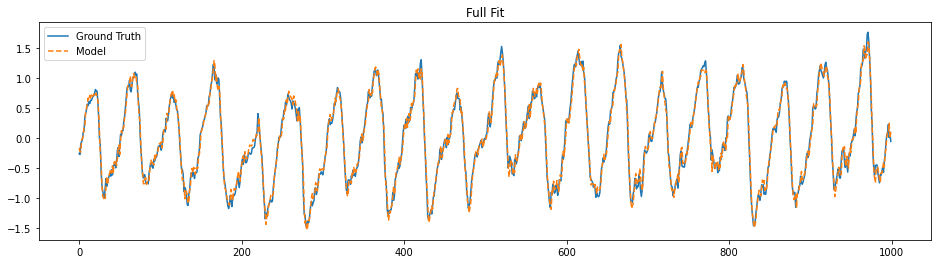

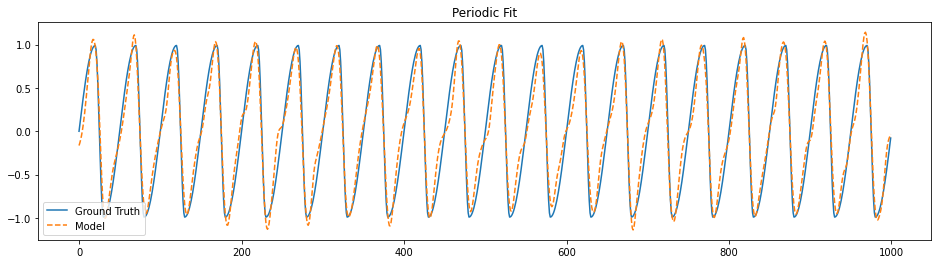

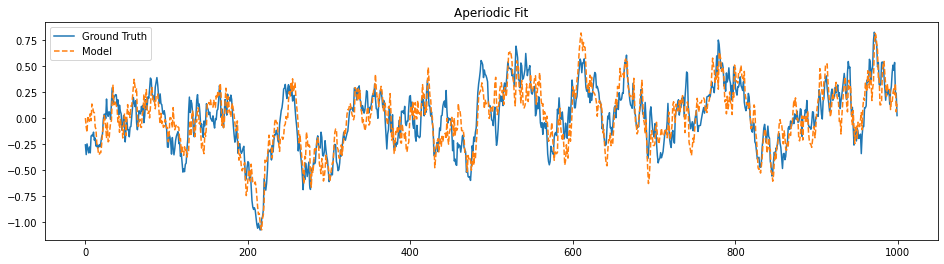

In [18]:
plt.figure(0, figsize=(16, 4))
plt.title('Full Fit')
plt.plot(ys, label='Ground Truth')
plt.plot(s+w, ls='--', label='Model')
plt.legend();

plt.figure(1, figsize=(16, 4))
plt.title('Periodic Fit')
plt.plot(osc, label='Ground Truth')
plt.plot(s, ls='--', label='Model')
plt.legend();

plt.figure(2, figsize=(16, 4))
plt.title('Aperiodic Fit')
plt.plot(lfp, label='Ground Truth')
plt.plot(w, ls='--', label='Model')
plt.legend();

In [6]:
params

{'ar_const': -0.004354787133884523,
 'ar_ar.L1': 0.9436225428304441,
 'ar_ar.L2': -0.009289699353290668,
 'ar_sigma2': 0.010751896834588359,
 'osc_height': array([2.03478528, 0.69013847, 1.93429847, 0.32602018, 0.15894677,
        0.03386131, 0.21364277, 0.06093179]),
 'osc_phis': array([-4.51899608e-01, -5.58157717e-01,  5.50832438e-01,  8.33995671e-04,
        -1.00000000e+00, -1.71472174e-01, -6.79639622e-01, -3.68122676e-01]),
 'osc_freqs': array([19.93897564, 19.83982543, 19.93588825, 19.85793998, 19.26400662,
        31.86636849, 20.2397502 , 21.31287679]),
 'osc_asym': array([-0.94591144,  0.18944785,  0.9994859 ,  1.        , -1.        ,
         1.        , -1.        ,  1.        ])}

In [11]:
ys = sig
xs = np.arange(len(ys))

s_order = 4
p_order = 0


bounds = [
    [0, -1, 1, -1] * s_order,
    [5,  1, 50, 1] * s_order
]


guess = [.5, 0, 20, 0] * s_order

osc_params = fit(xs, ys, fs, s_order, p_order, bounds=bounds, guess=guess, maxfev=1000)

s = decompose_ar(xs, ys, fs, s_order, p_order, *osc_params, return_components=True)

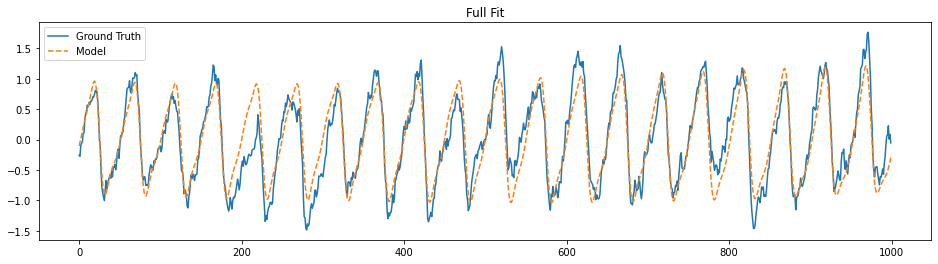

In [12]:
plt.figure(0, figsize=(16, 4))
plt.title('Full Fit')
plt.plot(ys, label='Ground Truth')
plt.plot(s, ls='--', label='Model')
plt.legend();


In [15]:
list(osc_params.reshape(s_order, -1))

[array([ 2.69927981e+00, -9.99999265e-01,  2.00099962e+01,  7.61487712e-03]),
 array([ 0.66339875, -0.51098492, 20.01628607, -1.        ]),
 array([ 2.39739071, -0.04464957, 20.04320954, -0.03450364]),
 array([ 0.36044691,  0.23743404, 19.65248649, -0.16639753])]